# Figure

inspired by Fig. 21 from Naidu et al. (2020): https://ui.adsabs.harvard.edu/abs/2020ApJ...901...48N

#### Author(s):
Sven Buder

#### History:
210408: Created

![](literature/2020ApJ...901..48N_Fig21.png)

In [3]:
# Preamble for notebook 

# Compatibility with Python 3
from __future__ import (absolute_import, division, print_function)

try:
    %matplotlib inline
    %config InlineBackend.figure_format='retina'
except:
    pass

# Basic packages
import warnings
warnings.filterwarnings("ignore")
import numpy as np
np.seterr(divide='ignore', invalid='ignore')
from astropy.table import Table, join
from sklearn import mixture

# Matplotlib and associated packages for plotting
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from matplotlib import patches

params = {
    'font.family'        : 'serif',
    'text.usetex'        : True, 
    'text.latex.preamble': [r'\usepackage{upgreek}', r'\usepackage{amsmath}'],
    }   
plt.rcParams.update(params)

In [4]:
def get_and_join_data(directory = '../data/'):
    
    # Join all data
    galah_dr3_main = Table.read(directory+'GALAH_DR3_main_allspec_v2.fits')
    galah_dr3_dynamics = Table.read(directory+'GALAH_DR3_VAC_dynamics_v2.fits')
    galah_dr3_gaiaedr3 = Table.read(directory+'GALAH_DR3_VAC_GaiaEDR3_v2.fits')
    galah_dr3_ages = Table.read(directory+'GALAH_DR3_VAC_ages_v2.fits')
    galah_dr3_rv = Table.read(directory+'GALAH_DR3_VAC_rv_v2.fits')
    data_12 = join(galah_dr3_main, galah_dr3_dynamics, keys='sobject_id')
    data_123 = join(data_12, galah_dr3_gaiaedr3, keys='sobject_id')
    data_1234 = join(data_123, galah_dr3_ages, keys='sobject_id')
    data = join(data_1234, galah_dr3_rv, keys='sobject_id')
    
    # get best rv and e_rv
    data['best_rv'] = np.zeros(len(data['sobject_id'])); data['best_rv'][:] = np.nan;
    data['best_rv'][data['use_rv_flag_1']==0] = data['rv_obst'][data['use_rv_flag_1']==0]
    data['best_rv'][data['use_rv_flag_1']==1] = data['rv_sme_v2'][data['use_rv_flag_1']==1]
    data['best_rv'][data['use_rv_flag_1']==2] = data['dr2_radial_velocity_1'][data['use_rv_flag_1']==2]

    data['best_e_rv'] = np.zeros(len(data['sobject_id'])); data['best_e_rv'][:] = np.nan;
    data['best_e_rv'][data['use_rv_flag_1']==0] = data['e_rv_obst'][data['use_rv_flag_1']==0]
    data['best_e_rv'][data['use_rv_flag_1']==1] = data['e_rv_sme'][data['use_rv_flag_1']==1]
    data['best_e_rv'][data['use_rv_flag_1']==2] = data['dr2_radial_velocity_error_1'][data['use_rv_flag_1']==2]
    
    # get best distance and 16th + 84th percentile
    data['best_d'] = np.zeros(len(data['sobject_id'])); data['best_d'][:] = np.nan;
    data['best_d_16'] = np.zeros(len(data['sobject_id'])); data['best_d_16'][:] = np.nan;
    data['best_d_50'] = np.zeros(len(data['sobject_id'])); data['best_d_50'][:] = np.nan;
    data['best_d_84'] = np.zeros(len(data['sobject_id'])); data['best_d_84'][:] = np.nan;

    data['best_d'][data['use_dist_flag']==0] = 1000.*data['distance_bstep'][data['use_dist_flag']==0]
    data['best_d_16'][data['use_dist_flag']==0] = 1000.*data['e16_distance_bstep'][data['use_dist_flag']==0]
    data['best_d_50'][data['use_dist_flag']==0] = 1000.*data['e50_distance_bstep'][data['use_dist_flag']==0]
    data['best_d_84'][data['use_dist_flag']==0] = 1000.*data['e84_distance_bstep'][data['use_dist_flag']==0]

    data['best_d'][data['use_dist_flag']==1] = data['r_med_photogeo'][data['use_dist_flag']==1]
    data['best_d_16'][data['use_dist_flag']==1] = data['r_lo_photogeo'][data['use_dist_flag']==1]
    data['best_d_50'][data['use_dist_flag']==1] = data['r_med_photogeo'][data['use_dist_flag']==1]
    data['best_d_84'][data['use_dist_flag']==1] = data['r_hi_photogeo'][data['use_dist_flag']==1]

    data['best_d'][data['use_dist_flag']==2] = data['r_med_geo'][data['use_dist_flag']==2]
    data['best_d_16'][data['use_dist_flag']==2] = data['r_lo_geo'][data['use_dist_flag']==2]
    data['best_d_50'][data['use_dist_flag']==2] = data['r_med_geo'][data['use_dist_flag']==2]
    data['best_d_84'][data['use_dist_flag']==2] = data['r_hi_geo'][data['use_dist_flag']==2]

    data['best_d'][data['use_dist_flag']==4] = 1000./data['parallax_corr'][data['use_dist_flag']==4]
    data['best_d_16'][data['use_dist_flag']==4] = 1000./(data['parallax_corr'][data['use_dist_flag']==4]+data['parallax_error'][data['use_dist_flag']==4])
    data['best_d_50'][data['use_dist_flag']==4] = 1000./(data['parallax_corr'][data['use_dist_flag']==4]-data['parallax_error'][data['use_dist_flag']==4])
    data['best_d_84'][data['use_dist_flag']==4] = 1000./data['r_hi_geo'][data['use_dist_flag']==4]

    data['theta_spherical'] = np.arctan2(data['R_Rzphi'], data['z_Rzphi'])
    data['rho_spherical'] = np.sqrt((data['R_Rzphi'])**2+(data['z_Rzphi'])**2)
    data['vrho_spherical'] = (data['R_Rzphi']*data['vR_Rzphi'] + data['z_Rzphi']*data['vz_Rzphi'])/data['rho_spherical']
    data['vtheta_spherical'] = (data['z_Rzphi']*data['vR_Rzphi'] - data['R_Rzphi']*data['vz_Rzphi'])/data['rho_spherical']

    return data

# test if joined data file already exists
try:
    data = Table.read('../../data/GALAH_DR3_all_joined_v2.fits')
except:
    data = get_and_join_data(directory = '../../data/')
    data.write('../../data/GALAH_DR3_all_joined_v2.fits')

In [5]:
basic_cuts = (
    (data['flag_sp'] == 0) &
    (data['flag_Mg_fe'] == 0) &
    np.isfinite(data['L_Z'])    
    )
# in TOPCAT: flag_sp == 0 & flag_Mg_fe == 0 & abs(L_Z) >= 0

basic_cuts_mgnacu = (
    (data['flag_sp'] == 0) &
    (data['flag_Mg_fe'] == 0) &
    (data['flag_Na_fe'] == 0) &
    (data['flag_Cu_fe'] == 0) &
    np.isfinite(data['L_Z']) &
    np.isfinite(data['age_bstep'])
    )
# in TOPCAT: flag_sp == 0 & flag_Na_fe == 0 & flag_Mg_fe == 0 & flag_Cu_fe == 0 & abs(L_Z) >= 0

In [6]:
naidu_information = dict()
naidu_information['Gaia–Sausage–Enceladus'] = (2684,0.42,-1.15,0.21)
naidu_information['Sagittarius'] = (675,0.24,-0.96,0.12)
naidu_information['High-α Disk + In Situ Halo'] = (950,0.15, -0.54,0.34)
naidu_information['Arjuna'] = (139,0.02, -1.20,0.24)
naidu_information['Metal-weak Thick Disk'] = (144,0.02, -1.12,0.32)
naidu_information['Aleph'] = (122,0.02, -0.51,0.19)
naidu_information['Wukong'] = (111,0.01, -1.58,0.24)
naidu_information['Helmi Streams'] = (91,0.01, -1.28,0.15)
naidu_information['Sequoia'] = (72,0.01, -1.59, 0.14)
naidu_information["I'itoi"] = (65,0.01, -2.39, 0.38)
naidu_information['Thamnos'] = (32,0.01, -1.90, 0.29)

In [7]:
# basic_cuts: flag_sp == 0 & flag_Na_fe == 0 & flag_Mg_fe == 0 & flag_Cu_fe == 0 & abs(L_Z) >= 0
group = dict()
group['1'] = [-2.50,-1.80,-0.30,+0.65] # basic_cuts & fe_h >= -2.50 & fe_h < -1.80 & Mg_fe >= -0.30 & Mg_Fe < 0.65
group['2'] = [-1.80,-1.40,+0.25,+0.65] # basic_cuts & fe_h >= -1.80 & fe_h < -1.40 & Mg_fe >= 0.25 & Mg_Fe < 0.65
group['3'] = [-1.80,-1.40,+0.15,+0.25] # basic_cuts & fe_h >= -1.80 & fe_h < -1.40 & Mg_fe >= 0.15 & Mg_Fe < 0.25
group['4'] = [-1.80,-1.40,+0.00,+0.15] # basic_cuts & fe_h >= -1.80 & fe_h < -1.40 & Mg_fe >= 0.00 & Mg_Fe < 0.15
group['5'] = [-1.80,-0.80,-0.30,+0.00] # basic_cuts & fe_h >= -1.80 & fe_h < -0.80 & Mg_fe >= -0.30 & Mg_Fe < 0.00
group['6'] = [-1.40,-0.80,+0.45,+0.65] # basic_cuts & fe_h >= -1.40 & fe_h < -0.80 & Mg_fe >= 0.45 & Mg_Fe < 0.65
group['7'] = [-1.40,-1.00,+0.25,+0.45] # basic_cuts & fe_h >= -1.40 & fe_h < -1.00 & Mg_fe >= 0.25 & Mg_Fe < 0.45
group['8'] = [-1.40,-1.00,+0.15,+0.25] # basic_cuts & fe_h >= -1.40 & fe_h < -1.00 & Mg_fe >= 0.15 & Mg_Fe < 0.25
group['9'] = [-1.40,-1.00,+0.00,+0.15] # basic_cuts & fe_h >= -1.40 & fe_h < -1.00 & Mg_fe >= 0.00 & Mg_Fe < 0.15
group['10'] = [-1.00,-0.80,+0.25,+0.45] # basic_cuts & fe_h >= -1.00 & fe_h < -0.80 & Mg_fe >= 0.25 & Mg_Fe < 0.45
group['11'] = [-1.00,-0.80,+0.15,+0.25] # basic_cuts & fe_h >= -1.00 & fe_h < -0.80 & Mg_fe >= 0.15 & Mg_Fe < 0.25
group['12'] = [-1.00,-0.80,+0.00,+0.15] # basic_cuts & fe_h >= -1.00 & fe_h < -0.80 & Mg_fe >= 0.00 & Mg_Fe < 0.15
group['13'] = [-0.80,-0.65,+0.25,+0.45] # basic_cuts & fe_h >= -0.80 & fe_h < -0.65 & Mg_fe >= 0.25 & Mg_Fe < 0.45
group['14'] = [-0.80,-0.65,+0.15,+0.25] # basic_cuts & fe_h >= -0.80 & fe_h < -0.65 & Mg_fe >= 0.15 & Mg_Fe < 0.25
group['15'] = [-0.80,-0.65,+0.00,+0.15] # basic_cuts & fe_h >= -0.80 & fe_h < -0.65 & Mg_fe >= 0.00 & Mg_Fe < 0.15

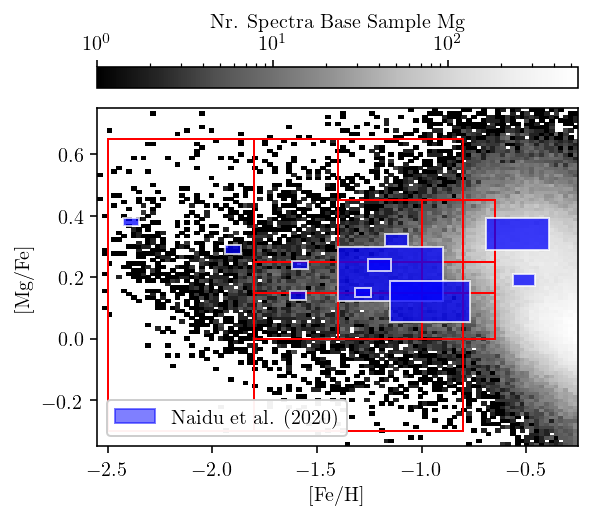

In [8]:
f, ax = plt.subplots(1,figsize=(4,3.5),constrained_layout=True)

p,x,y,s = ax.hist2d(
    data['fe_h'][basic_cuts],
    data['Mg_fe'][basic_cuts],
    bins=(np.linspace(-2.55,-0.25,100),np.linspace(-0.35,0.75,100)),
    cmin=1,norm=LogNorm(),cmap='Greys_r'
);
c = plt.colorbar(s,ax=ax,location='top')
c.set_label('Nr. Spectra Base Sample Mg')

for each in group:
    
    rect = patches.Rectangle((group[each][0], group[each][2]), group[each][1]-group[each][0], group[each][3]-group[each][2], linewidth=1, edgecolor='r', facecolor='none')
    ax.add_patch(rect)
    
for each in naidu_information.keys():
    
    sizex = np.sqrt(0.6*naidu_information[each][1])#np.sqrt(0.75*naidu_information[each][1])
    sizey = np.sqrt(0.075*naidu_information[each][1])#np.sqrt(0.06*naidu_information[each][1])
    
    rect = patches.Rectangle(
        (naidu_information[each][2]-0.5*sizex, naidu_information[each][3]-0.5*sizey), sizex, sizey, linewidth=1, edgecolor='white', facecolor='blue',alpha=0.75)
    ax.add_patch(rect)
    
blue_patch = patches.Patch(color='blue', alpha=0.5,label='Naidu et al. (2020)')
plt.legend(handles=[blue_patch],loc='lower left',framealpha=0.95)

ax.set_xlabel(r'$\mathrm{[Fe/H]}$')
ax.set_ylabel(r'$\mathrm{[Mg/Fe]}$');
plt.savefig('feh_mge_naidu.png',dpi=300,bbox_inches='tight')